# Personalization - A Data Example

For this project, I am interested in using the email marketing data to answer the following questions:

* How do user factors and email characteristics relate to email click-through rate (CTR)?

* What combination of user and email characteristics does the data suggest to have the highest email click-through rate?

* If we were to provide any insights on email campaign personalization for the marketing team, what can we propose based on the analysis results?



### Data Understanding and Preparation

In [1]:
# read in libraries and the dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
%matplotlib inline

data = pd.read_csv('./data.csv')
data.head(10)

,email_id,email_text,email_version,hour,weekday,user_country,user_past_purchases,clicked
0,8,short_email,generic,9,Thursday,US,3,0
1,33,long_email,personalized,6,Monday,US,0,0
2,46,short_email,generic,14,Tuesday,US,3,0
3,49,long_email,personalized,11,Thursday,US,10,0
4,65,short_email,generic,8,Wednesday,UK,3,0
5,66,long_email,generic,12,Wednesday,US,0,0
6,72,short_email,generic,4,Saturday,US,0,0
7,73,long_email,generic,18,Thursday,FR,5,0
8,82,long_email,personalized,17,Thursday,ES,0,0
9,114,short_email,personalized,5,Wednesday,US,2,0


In [2]:
# take a look at some characteristics of the data
data.shape

(99950, 8)

In [3]:
data.dtypes

email_id                int64
email_text             object
email_version          object
hour                    int64
weekday                object
user_country           object
user_past_purchases     int64
clicked                 int64
dtype: object

In [4]:
data.describe() # for numeric variables only

,email_id,hour,user_past_purchases,clicked
count,99950.000000,99950.000000,99950.000000,99950.00000
mean,498695.729065,9.059100,3.878559,0.02070
std,289226.115244,4.439618,3.196324,0.14238
min,8.000000,1.000000,0.000000,0.00000
25%,246721.500000,6.000000,1.000000,0.00000
50%,498441.500000,9.000000,3.000000,0.00000
75%,749936.750000,12.000000,6.000000,0.00000
max,999998.000000,24.000000,22.000000,1.00000


In [5]:
data.isnull().mean() # looks like this dataset does not contain any missing values - hooray!

email_id               0.0
email_text             0.0
email_version          0.0
hour                   0.0
weekday                0.0
user_country           0.0
user_past_purchases    0.0
clicked                0.0
dtype: float64

Now let's prepare the data for modeling

In [6]:
# email id is a unique identifier of the email and will not be useful in our prediction model
data = data.drop(labels='email_id',axis = 1)

# need to dummy code the categorical variables first 
# so that we can use them in our machine learning models
data_dummy = pd.get_dummies(data,drop_first=True)

In [7]:
# take a quick look at the processed daraframe before moving forward to the next stage
data_dummy.head(10)

,hour,user_past_purchases,clicked,email_text_short_email,email_version_personalized,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday,user_country_FR,user_country_UK,user_country_US
0,9,3,0,1,0,0,0,0,1,0,0,0,0,1
1,6,0,0,0,1,1,0,0,0,0,0,0,0,1
2,14,3,0,1,0,0,0,0,0,1,0,0,0,1
3,11,10,0,0,1,0,0,0,1,0,0,0,0,1
4,8,3,0,1,0,0,0,0,0,0,1,0,1,0
5,12,0,0,0,0,0,0,0,0,0,1,0,0,1
6,4,0,0,1,0,0,1,0,0,0,0,0,0,1
7,18,5,0,0,0,0,0,0,1,0,0,1,0,0
8,17,0,0,0,1,0,0,0,1,0,0,0,0,0
9,5,2,0,1,1,0,0,0,0,0,1,0,0,1


### Modeling and Analysis

To answer the first and the second questions, our outcome variable of interest is the binary variable *clicked*, which tells whether or not the marketing emails they've sent have been clicked through by the user for at least once (1/0).

In order to understand whether any factors about the user or the email contributed to the chance of the marketing message being clicked through, we will divide the data by these variables and take a look at the group-specific CTRs. 

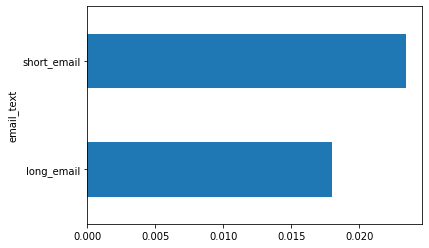

In [18]:
# by length of text (long vs. short)
groupby_t = data.groupby(['email_text']).mean()['clicked'].sort_values()
groupby_t.plot(kind = 'barh');

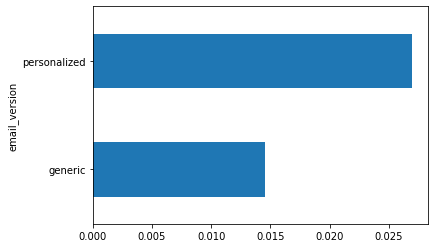

In [15]:
# by email version (personalized vs. generic)
groupby_ver = data.groupby(['email_version']).mean()['clicked'].sort_values()
groupby_ver.plot(kind = 'barh');

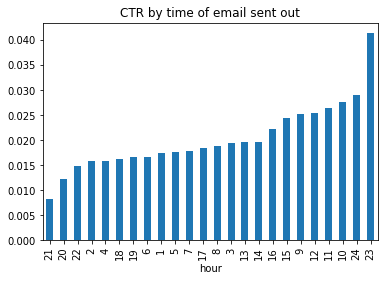

In [17]:
# by hour of the day that the email was sent (user local time)
groupby_h = data.groupby(['hour']).mean()['clicked'].sort_values()
groupby_h.plot(kind='bar',title= 'CTR by time of email sent out'); 
# looking at the time alone, emails that were sent at 11PM appears to have received the most attention from users

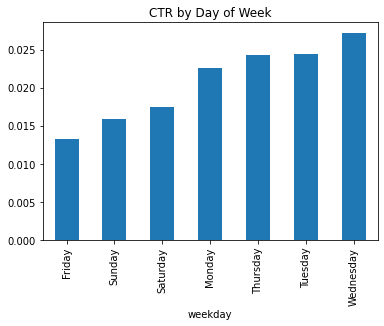

In [19]:
# by day of the week
groupby_w = data.groupby(['weekday']).mean()['clicked'].sort_values()
groupby_w.plot(kind='bar',title= 'CTR by Day of Week');

In [20]:
# combine the day and time
clicked_by_weekday_hour = pd.concat([pd.DataFrame(data[data['weekday']==i].groupby(['hour']).mean()['clicked']) for i in ['Monday','Tuesday','Wednesday','Thursday','Friday', 'Saturday','Sunday']],axis = 1)
clicked_by_weekday_hour.columns = ['Monday','Tuesday','Wednesday','Thursday','Friday', 'Saturday','Sunday']

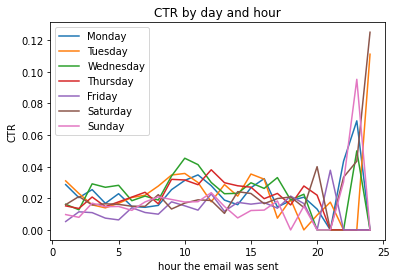

In [21]:
pd.set_option('display.max_columns', 20)
pd.set_option('display.width', 350)
clicked_by_weekday_hour.plot(xlabel = 'hour the email was sent',ylabel = 'CTR',title = 'CTR by day and hour',x_compat=True);

In [22]:
groupby_wh = data.groupby(['weekday','hour']).mean()['clicked'].sort_values(ascending = False)
groupby_wh.head(20)

weekday    hour
Saturday   24      0.125000
Tuesday    24      0.111111
Sunday     23      0.095238
Monday     23      0.068966
Wednesday  23      0.050000
           10      0.045336
Monday     22      0.043478
Saturday   23      0.043478
Wednesday  11      0.041284
Saturday   20      0.040000
Thursday   12      0.038031
Friday     21      0.037736
Tuesday    10      0.035714
           15      0.035343
Monday     11      0.034799
Tuesday    9       0.034705
Wednesday  9       0.034061
Saturday   22      0.033333
Wednesday  17      0.033088
Monday     16      0.032432
Name: clicked, dtype: float64

In [23]:
# by country where the user is located
groupby_c = data.groupby(['user_country']).mean()['clicked'].sort_values()
groupby_c.head()

user_country
FR    0.007408
ES    0.008029
US    0.023873
UK    0.024137
Name: clicked, dtype: float64

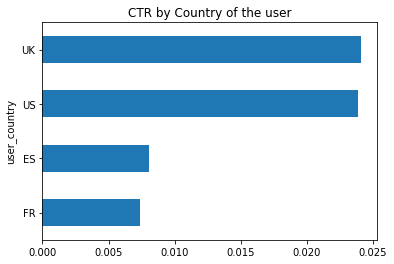

In [25]:
groupby_c.plot(kind='barh',title= 'CTR by Country of the user');

In [30]:
# by amount of past purchases
groupby_p = data.groupby(['user_past_purchases']).mean()['clicked'].sort_values(ascending=True)
groupby_p.tail(5)

user_past_purchases
15    0.117021
16    0.117647
19    0.200000
21    0.500000
22    1.000000
Name: clicked, dtype: float64

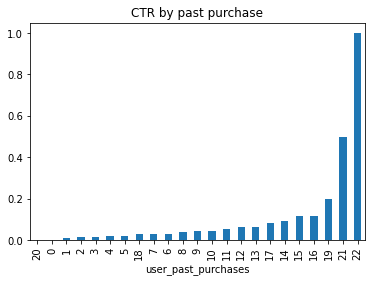

In [28]:
groupby_p.plot(kind='bar',title= 'CTR by past purchase');

To answer the second question, let's train a classification model to predict the marketing email click-through outcomes for any unique combination of user and email factors.  

Before building the model, we will want to split the data into training and test sets to make sure we are not building models that overfit the data and do not generalize well to new situations. The [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) method from scikit-learn comes very handy for completing this step. 

In [31]:
np.random.seed(1) # to be able to reproduce results

In [32]:
train, test = train_test_split(data_dummy, test_size = 0.33)

#Random Forest method is chosen to solve this classification problem. 
# It is particularly useful in reducing the chance of overfitting. 
model = RandomForestClassifier(class_weight={0:0.05,1:0.95}, n_estimators=50, oob_score=True)
model.fit(train.drop('clicked', axis=1), train['clicked']) # may take a few seconds to run

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"


RandomForestClassifier(class_weight={0: 0.05, 1: 0.95}, n_estimators=50,
                       oob_score=True)

In [34]:
# to assess how well our prediction matches the truth, 
# we can take a look at the test set confusion matrix
y_test = test['clicked']
y_pred = model.predict(test.drop('clicked', axis=1)) # use the fitted model to predict label for the test set
pd.DataFrame(confusion_matrix(y_test,y_pred)) # print the test set confusion matrix

,0,1
0,30652,1654
1,603,75


Our model managed to correctly predict around 11% (75/678) of the *clicked*. This may seem pretty low, but it is a fairly acceptable result as in real world we often do not get perfect prediction. With that being said, there're certainly ways to improve this result, for example, by tweaking the model parameters.

In [35]:
# we only have a very small proportion (~2%) of clicks among all data points
# data_dummy['clicked'].mean()

The next step will be to, with the model we just built, estimate the probability of being clicked for each unique combination of the user and email characteristics. 

I would be curious to know what combination of user country, number of past purchase, length of text, version, and day and time gives us the best CTR among all.

In [ ]:
data_comb = data_dummy.drop(['clicked'],axis = 1).drop_duplicates() # keep all unique combinations of characteristic variables
#data_comb.head()

In [38]:
y_comb = model.predict_proba(data_comb) 
# this estimates the probabilities of getting a label of 0/1 for each row

data_comb['pred_clicked'] = [x[1] for x in y_comb]

In [40]:
# now let's take a look at the combinations of user and email characteristics 
# ordered by their predicted probability of clicked-through in descending order (from best to worst)
data_comb = data_comb.sort_values(by=['pred_clicked'],ascending=False)
data_comb.head()

,hour,user_past_purchases,email_text_short_email,email_version_personalized,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday,user_country_FR,user_country_UK,user_country_US,pred_clicked
14399,12,9,1,1,0,1,0,0,0,0,0,0,1,0.951077
57768,4,11,0,1,0,0,0,0,0,1,0,0,1,0.946538
8548,9,10,1,1,0,0,0,0,1,0,0,0,1,0.946121
3964,8,8,1,0,0,0,0,0,1,0,0,1,0,0.940000
3379,4,15,1,0,1,0,0,0,0,0,0,0,1,0.900000


According to the output, a short (<=3 paragraphs) and personalized email sent on Saturday at 12pm to US customers who have bought 9 items would have the highest chance of being clicked (~95.1%). We can interpret all other combinations in a similar manner. For example, the model predicts that a long (>3 paragraph) and personalized email sent on Wednesday at 4am to US customers who have purchased 11 items has a 94.7% probability of being clicked. 

Lastly, it's our turn to provide insights on email campaign personalization for the marketing team - we will take one step further and identify the non-user characteristics (i.e. factors about the email that we can manipulate) that maximize the chance of being clicked for each user group.

In [42]:
# first divide the # of purchase variable into 3 groups: Never purchased, <=10 items, >10 items
# to avoid having too many user groups 
data_comb['purchase_group']=pd.cut(data_comb['user_past_purchases'], bins=[0,1,11,23], include_lowest=True, right=False, labels=['Never_purchased', 'Below_or_equal_10', 'Over_10'])

# drop the original numeric variable
data_comb = data_comb.drop(labels = 'user_past_purchases',axis = 1)

In [43]:
# remove all duplicates so only the unique user groups with the highest probability of clicking is kept 
# should have a total of 12 user groups = 4 countries * 3 purchase_groups
best_segment = data_comb.drop_duplicates(subset=['user_country_FR', 'user_country_UK', 'user_country_US', 
                                         'purchase_group']).copy()

In [44]:
# This returns the combination of email characteristics for each user group that have best chance of clicking.
# Note that users who have never purchased an item seem to always have the lowest chance of clicking, 
# regardless of where they are located (which may not be very surprising). 
best_segment.sort_values(by='pred_clicked',ascending=False)

,hour,email_text_short_email,email_version_personalized,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday,user_country_FR,user_country_UK,user_country_US,pred_clicked,purchase_group
14399,12,1,1,0,1,0,0,0,0,0,0,1,0.951077,Below_or_equal_10
57768,4,0,1,0,0,0,0,0,1,0,0,1,0.946538,Over_10
3964,8,1,0,0,0,0,0,1,0,0,1,0,0.940000,Below_or_equal_10
31953,5,1,1,1,0,0,0,0,0,0,1,0,0.829358,Over_10
35971,15,1,1,0,0,0,0,1,0,0,0,0,0.808454,Below_or_equal_10
41515,14,1,1,0,0,0,1,0,0,1,0,0,0.740000,Below_or_equal_10
6811,14,1,0,1,0,0,0,0,0,0,0,0,0.700000,Over_10
51586,6,0,0,0,0,0,0,0,1,1,0,0,0.660000,Over_10
3423,13,1,1,0,0,0,0,1,0,0,0,1,0.515967,Never_purchased
58113,10,1,0,0,0,0,0,1,0,0,0,0,0.092714,Never_purchased



### To conclude

Now we have the email campaign strategy for every user group (categoried by their country and number of purchases) that is predicted to have the highest chance of clicking through the email. We can present the results above to the marketing team and recommend sending their email campaigns accordingly. 

Of course, there's always room to improve our models, by further tuning the parameters or trying other ML algorithms with better performance on such tasks, etc. We did not dive deep into this technical aspect since the focus of this analysis is really to present to audiences a real-world application of how data science can be used to: 

* providing meaningful insights that help with business decisions,

* and generating personalized strategies to drive future improvements or innovations.

But feel free to continue from here and explore further if you are interested! 